# SVM TO CLASSIFY IMAGES OF CATS AND DOGS

A high‑accuracy classifier that distinguishes cats from dogs using an SVM trained on deep features extracted by MobileNetV2.

**Key steps**  
1. Load and unzip the Kaggle *train.zip* to Google Drive  
2. Pre‑process & resize images (128 × 128)  
3. Extract 1280‑D feature vectors via MobileNetV2 (pre‑trained on ImageNet)  
4. Train a Linear SVM  
5. Evaluate with accuracy, precision/recall/F1, and a confusion matrix  

**MOUNT GOOGLE DRIVE**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**UNZIP DATASET**

In [4]:
import zipfile

zip_path = '/content/drive/MyDrive/SVMDataset/train.zip'
extract_path = '/content/data/train'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [5]:
import os
dataset_path ="/content/data/train/train"

**LOAD AND PRE-PROCESS DATA**

In [6]:
import cv2
import numpy as np
from tqdm import tqdm

IMG_SIZE = 128
LIMIT = 4000

def load_images_with_labels(folder_path, limit):
    images, labels = [], []
    count = 0
    for img_name in tqdm(os.listdir(folder_path)):
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            label = 'dog' if 'dog' in img_name else 'cat'
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                images.append(img)
                labels.append(label)
                count += 1
            if count >= limit:
                break
    return np.array(images), np.array(labels)

X_raw, y = load_images_with_labels(dataset_path, LIMIT)

 16%|█▌        | 3999/25000 [00:04<00:22, 923.35it/s] 


**VISUAL CHECK**

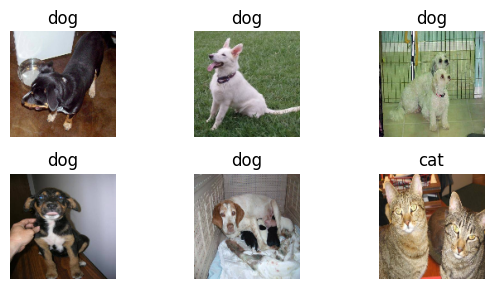

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,3))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(cv2.cvtColor(X_raw[i], cv2.COLOR_BGR2RGB))
    plt.axis('off'); plt.title(y[i])
plt.tight_layout(); plt.show()

**FEATURE EXTRACTION WITH MobileNetV2**

In [9]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

X_processed = preprocess_input(X_raw)
mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), pooling='avg')
print("X_raw shape:", X_raw.shape)
print("X_processed shape:", X_processed.shape)
features = mobilenet.predict(X_processed, batch_size=32, verbose=1)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
X_raw shape: (4000, 128, 128, 3)
X_processed shape: (4000, 128, 128, 3)
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step


**TRAIN-TEST SPLIT**

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(features, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

**TRAIN SVM**

In [11]:
from sklearn.svm import SVC

svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

**MODEL EVALUATION**

Accuracy: 0.95375

Classification Report:
               precision    recall  f1-score   support

         cat       0.95      0.96      0.96       412
         dog       0.95      0.95      0.95       388

    accuracy                           0.95       800
   macro avg       0.95      0.95      0.95       800
weighted avg       0.95      0.95      0.95       800



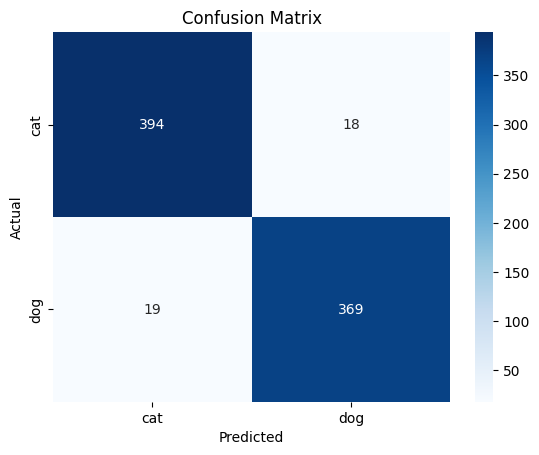

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = svm_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [13]:
import os
os.path.exists('/content/drive/MyDrive/SVMDataset/download.jpg')

True

**PREDICTION ON SINGLE IMAGE**

In [16]:
def predict_image(path):
    img = cv2.imread(path)
    if img is None:
        print("❌ Image not found or path is incorrect!")
        return

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    vec = mobilenet.predict(preprocess_input(img[None, ...]))
    pred = svm_model.predict(vec)
    print('✅ Prediction:', le.inverse_transform(pred)[0])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.axis('off')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
✅ Prediction: dog


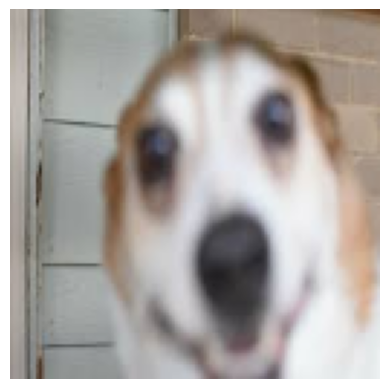

In [17]:
predict_image('/content/drive/MyDrive/SVMDataset/download.jpg')

**SAVING MODEL**

In [18]:
import joblib, pickle
joblib.dump(svm_model,    '/content/drive/MyDrive/SVMDataset/svm_model.pkl')
pickle.dump(le,     open('/content/drive/MyDrive/SVMDataset/label_encoder.pkl','wb'))
mobilenet.save('/content/drive/MyDrive/SVMDataset/mobilenet_feature_extractor.h5')
print('✅ Models saved to Google Drive')

✅ Models saved to Google Drive
